In [1]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)

%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np

root = Settings['data_root']

#frame = 1
#resize = 0.5

mot16 = MOT16(root)

# the training set contains both detection as well as ground-truth data
# while the test set only contains detection data.
X, Y_det, Y_gt = mot16.get_train("MOT16-02", memmapped=True)

DM = np.load('MOT16_02.npy')

print("")
print("X:", X.shape)
print("DM:", DM.shape)

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}
/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded

X: (600, 1080, 1920, 3)
DM: (600,)


In [2]:
import numpy as np
from math import sqrt

def get_visible_pedestrains(frame):
    Y_gt_frame1 = utils.extract_eq(Y_gt, col=0, value=frame)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=7, value=1)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=8, value=1)
    return Y_gt_frame1

nbr_frames = 100
D = []
for i in range(nbr_frames):
    D.append(get_visible_pedestrains(i+1))
D = np.concatenate(D).astype('int64')

def is_inside_bb(bb, u,v):
    x,y,w,h = bb
    return u >= x and u < x+w and \
        v >= y and v < y+h

def calculate_feature(one, two):
    i, pid1, x1, y1, bb_w1, bb_h1, _, _, _ = one
    j, pid2, x2, y2, bb_w2, bb_h2, _, _, _ = two
    
    # --------------- f_st ---------------
    
    h = (bb_h1 + bb_h2) / 2.0
    f_st =  sqrt((x1 - x2)**2 + (y1 - y2)**2) / h
    
    # --------------- f_dm ---------------
    
    
    f_dm = 0
    
    if (j - i) >= 30:
        f_dm = 0.  # we know nothing
    else:
        intersections = 0
        unions = 0

        for M in DM[i][max(j-i-1, 0)]:
            if i == j:    
                inside_one = is_inside_bb((x1,y1,bb_w1,bb_h1), M[0], M[1])
                inside_two = is_inside_bb((x2,y2,bb_w2,bb_h2), M[0], M[1])
            else:
                inside_one = is_inside_bb((x1,y1,bb_w1,bb_h1), M[0], M[1])
                inside_two = is_inside_bb((x2,y2,bb_w2,bb_h2), M[2], M[3])

            if inside_one and inside_two:
                intersections += 1
            if inside_one or inside_two:
                unions += 1

        if unions > 0:
            f_dm = intersections/unions
        else:
            f_dm = 0.  # we know nothing

    return (f_st, f_dm)

In [4]:
# for i, entry in enumerate(Table):
#         f, pid, bb_left, bb_right, bb_w, bb_h, _, _, _ = entry
#         for j in range(i+1, min(n)):
#             f_o, pid_o, bb_left_o, bb_right_o, bb_w_o, bb_h_o, _, _, _ = Table[j]
            
#             cost = calculate_cost(entry, Table[j])
#             #print('cost:', cost)
#             #cost = 10 if pid == pid_o else -1
            
#             if abs(f_o - f) > dst_theta:
#                 # lifted edge
#                 lifted_edges.append((i,j,cost))
#             else:
#                 # normal edge
#                 edges.append((i,j,cost))
            
#             ALL_EDGES.append((i, j, cost))

2.4731
1.2369
0.40858
0.26749
0.18023
0.16075
-0.011851
-0.185
-0.18665
-0.25086
-0.28739
-0.30087
-0.30663
-0.3541


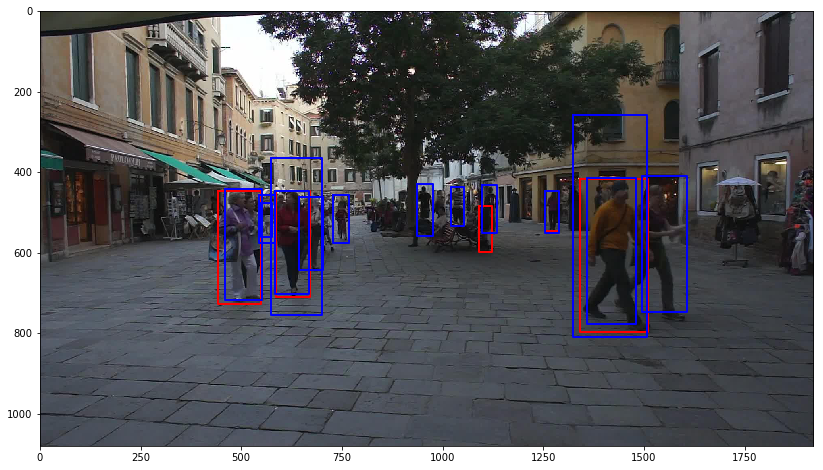

In [5]:
#X, Y_det, Y_gt

def get_visible_pedestrains_det(frame):
    Y_det_frame1 = utils.extract_eq(Y_det, col=0, value=frame)
    return Y_det_frame1

def get_bb(i, D):
    left = D[i,2]
    top = D[i,3]
    width = D[i,4]
    height = D[i,5]
    return left, top, width, height

frame = 2

fig  = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(X[frame])

ped_gt = get_visible_pedestrains(frame)
for ped in ped_gt:
    f1, pid1, l, t, w, h, _, _, _ = ped
    bbX, bbY = utils.bb_to_plt_plot(l, t, w, h)
    ax.plot(bbX, bbY, linewidth=2, color='red')
    
ped_det = get_visible_pedestrains_det(frame)
for ped in ped_det:
    f1, _,l, t, w, h, score, _, _,_ = ped
    bbX, bbY = utils.bb_to_plt_plot(l, t, w, h)
    print(score)
    ax.plot(bbX, bbY, linewidth=2, color='blue')

plt.show()